In [1]:
!pip install nfts
!pip install tweepy --ignore-installed certifi
!pip install web3

  Using cached tweepy-4.6.0-py2.py3-none-any.whl (69 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl (149 kB)
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.2.0-py3-none-any.whl (151 kB)
  Using cached idna-3.3-py3-none-any.whl (61 kB)
  Using cached urllib3-1.26.9-py2.py3-none-any.whl (138 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)


In [60]:
import nfts.dataset
import tweepy
from web3 import Web3
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import datetime
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# inspired by https://github.com/yalinyener/TwitterSentimentAnalysis

class TweetSentimentAnalyzer:
    def __init__(self, query, start_date, end_date, interval, tweets_per_interval, api):
        self.query = query
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.tweets_per_interval = tweets_per_interval
        self.api = api

        self.df_aggregated = pd.DataFrame(columns = ['interval_start', 'interval_end', 'positive', 'negative', 'neutral'])
        self.df_full = pd.DataFrame(columns = ['text', 'sentiment'])
    
    def create_dataframes(self):
        start = self.start_date
        end = start + datetime.timedelta(days = self.interval)
        
        while end <= self.end_date:
            tweets = self.paginated_tweets(start, end)
            
            positive  = 0
            negative = 0
            neutral = 0
            
            for tweet in tweets:
                tweet_cleaned = TweetSentimentAnalyzer.clean_tweet(tweet.text)
                score = SentimentIntensityAnalyzer().polarity_scores(tweet_cleaned)
                neg = score['neg']
                neu = score['neu']
                pos = score['pos']
                sentiment = ''
                
                if neg > pos:
                    negative += 1
                    sentiment = 'negative'
                elif pos > neg:
                    positive += 1
                    sentiment = 'positive'
                elif pos == neg:
                    neutral += 1
                    sentiment = 'neutral'
                
                self.df_full = self.df_full.append({ 'text': tweet.text, 'sentiment': sentiment }, ignore_index = True)

            num_tweets = len(tweets)
            positive_percent = round(TweetSentimentAnalyzer.percentage(positive, num_tweets), 2)
            negative_percent = round(TweetSentimentAnalyzer.percentage(negative, num_tweets), 2)
            neutral_percent = round(TweetSentimentAnalyzer.percentage(neutral, num_tweets), 2)
            
            self.df_aggregated = self.df_aggregated.append({
                'interval_start': start,
                'interval_end': end,
                'positive': positive_percent,
                'negative': negative_percent,
                'neutral': neutral_percent
            }, ignore_index = True)
            
            print('tweets analyzed for interval starting at: ', start.strftime('%m/%d/%y'))
            
            start = end
            end = start + datetime.timedelta(days = self.interval)
            
    def visualize_aggregated_sentiment(self):
        plt.plot_date(self.df_aggregated.interval_start, self.df_aggregated.positive, linestyle = '-', color = 'g', label = 'positive')
        plt.plot_date(self.df_aggregated.interval_start, self.df_aggregated.negative, linestyle = '-', color = 'r', label = 'negative')
        plt.plot_date(self.df_aggregated.interval_start, self.df_aggregated.neutral, linestyle = '-', color = 'black', label = 'neutral')
        plt.xticks(rotation = 45)
        plt.title('Average Sentiment Over Time (' + self.query + ')')
        plt.xlabel('Interval Start')
        plt.ylabel('Average Sentiment (%)')
        plt.legend(loc = 'upper left')
        plt.show()
            
    def visualize_sentiment(self, sentiment):
        wc = WordCloud()
        df_sentiment = self.df_full[self.df_full['sentiment'] == sentiment]
        cluster = " ".join(df_sentiment.text)
        plt.imshow(wc.generate(cluster), interpolation = 'bilinear')
        plt.title(self.query + ' ' + sentiment.capitalize() + ' Tweets')
        plt.show()
        
    def paginated_tweets(self, start, end):
        tweets = []
        tweet_count = 0
        next_token = -1
        
        while next_token is not None and tweet_count < self.tweets_per_interval:
            response = self.api.search_all_tweets(
                query = self.query,
                start_time = start,
                end_time = end,
                max_results = self.tweets_per_interval,
                next_token = None if next_token == -1 else next_token
            )

            for tweet in response.data:
                if tweet_count == self.tweets_per_interval:
                    break

                tweets.append(tweet)
                tweet_count += 1

            next_token = response.meta['next_token']
            time.sleep(1)

        return tweets
    
    @staticmethod
    def percentage(part, whole):
        return 100 * float(part) / float(whole)
    
    @staticmethod
    def clean_tweet(tweet):
        stemmer = PorterStemmer()
        stop_words = set(stopwords.words('english'))

        tweet_cleaned = word_tokenize(tweet)
        tweet_cleaned = [w for w in tweet_cleaned if w not in string.punctuation]
        tweet_cleaned = [w for w in tweet_cleaned if w not in stop_words]
        tweet_cleaned = [w.lower() for w in tweet_cleaned]
        tweet_cleaned = [stemmer.stem(w) for w in tweet_cleaned]

        return " ".join(tweet_cleaned)

In [5]:
class NFTPriceAggregator:
    def __init__(self, collection, start_date, end_date, interval, nfts, transfers):
        self.collection = collection
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval

        self.transfers = NFTPriceAggregator.get_transfers_for_collection(collection, nfts, transfers)
        self.transfers['datetime'] = self.transfers['timestamp'].apply(datetime.datetime.fromtimestamp)

        self.df = pd.DataFrame(columns = ['interval_start', 'interval_end', 'average_price'])
        
    def create_dataframe(self):
        start = self.start_date
        end = start + datetime.timedelta(days = self.interval)
        
        while end <= self.end_date:
            transfers_in_interval = self.transfers[self.transfers['datetime'].between(start, end)]

            self.df = self.df.append({
                'interval_start': start,
                'interval_end': end,
                'average_price': transfers_in_interval['transaction_value_eth'].mean()
            }, ignore_index = True)
            
            start = end
            end = start + datetime.timedelta(days = self.interval)

        self.df['average_price_normalized'] = (self.df['average_price'] - self.df['average_price'].mean()) / self.df['average_price'].std()
    
    def visualize_aggregated_prices(self):
        plt.plot_date(self.df.interval_start, self.df.average_price, linestyle = '-')
        plt.xticks(rotation = 45)
        plt.title('Average Price of ' + self.collection + ' Over Time')
        plt.xlabel('Interval Start')
        plt.ylabel('Average Price (in ETH)')
        plt.show()
    
    @staticmethod
    def get_transfers_for_collection(collection, nfts, transfers):
        address = nfts[nfts['symbol'] == collection].iloc[0, :].address
        return transfers[transfers['nft_address'] == address]

In [6]:
class CryptoPriceAggregator:
    def __init__(self, asset, start_date, end_date, interval, prices):
        self.asset = asset
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.prices = prices

        self.df = pd.DataFrame(columns = ['interval_start', 'interval_end', 'average_price'])
        
    def create_dataframe(self):
        start = self.start_date
        end = start + datetime.timedelta(days = self.interval)
        
        while end <= self.end_date:
            temp_df = self.prices[self.prices.name == self.asset][(self.prices.date > start) & (self.prices.date <= end)]
            mean_value = temp_df['average_price'].str.replace('$','').str.replace(',','').astype('float').mean()

            self.df = self.df.append({
                'interval_start': start,
                'interval_end': end,
                'average_price': mean_value
            }, ignore_index = True)
            
            start = end
            end = start + datetime.timedelta(days = self.interval)
        
        self.df['average_price_normalized'] = (self.df['average_price'] - self.df['average_price'].mean()) / self.df['average_price'].std()
    
    def visualize_aggregated_prices(self):
        plt.plot_date(self.df.interval_start, self.df.average_price, linestyle = '-')
        plt.xticks(rotation = 45)
        plt.title('Average Price of ' + self.asset + ' Over Time')
        plt.xlabel('Interval Start')
        plt.ylabel('Average Price')
        plt.show()

In [10]:
class CryptoTopicCombiner:
    def __init__(self, collections, assets, interval):
        self.collections = collections
        self.assets = assets
        self.interval = interval

        self.df = pd.DataFrame(
            columns = [
                'interval_start',
                'interval_end',
                'average_price',
                'average_price_normalized',
                'positive',
                'negative',
                'neutral',
                'asset',
                'query'
            ]
        )

        self.analyzers = {}
        self.nft_aggregators = {}
        self.crypto_aggregators = {}
    
    def set_analyzer_args(self, *args):
        self.analyzer_args = args
    
    def set_nft_aggregator_args(self, *args):
        self.nft_aggregator_args = args
        
    def set_crypto_aggregator_args(self, *args):
        self.crypto_aggregator_args = args
        
    def generate_row(self, name, data, is_nft):
        start = datetime.datetime.strptime(data['start_date'], '%m/%d/%y')
        end = datetime.datetime.strptime(data['end_date'], '%m/%d/%y')

        analyzer = TweetSentimentAnalyzer(data['query'], start, end, self.interval, *self.analyzer_args)
        analyzer.create_dataframes()
        self.analyzers[name] = analyzer
        
        if is_nft:
            aggregator = NFTPriceAggregator(name, start, end, self.interval, *self.nft_aggregator_args)
            self.nft_aggregators[name] = aggregator
        else:
            aggregator = CryptoPriceAggregator(name, start, end, self.interval, *self.crypto_aggregator_args)
            self.crypto_aggregators[name] = aggregator
        
        aggregator.create_dataframe()

        combined = aggregator.df.merge(analyzer.df_aggregated, on = ['interval_start', 'interval_end'])
        combined['asset'] = name
        combined['query'] = data['query']
        self.df = self.df.append(combined, ignore_index = True)
        
    def create_dataframe(self):
        for collection, data in self.collections.items():
            self.generate_row(collection, data, True)

        for asset, data in self.assets.items():
            self.generate_row(asset, data, False)

In [8]:
# https://www.kaggle.com/datasets/simiotic/ethereum-nfts
DATASET_PATH = './nfts.sqlite'

ds = nfts.dataset.FromSQLite(DATASET_PATH)

In [9]:
transfers_df = ds.load_dataframe('transfers')

In [11]:
transfers_df['transaction_value_eth'] = transfers_df['transaction_value'].apply(lambda wei: Web3.fromWei(wei, 'ether'))

In [12]:
transfers_df.head()

,event_id,transaction_hash,block_number,nft_address,token_id,from_address,to_address,transaction_value,timestamp,transaction_value_eth
0,cd816651-56b2-4ed9-887c-c83de732428d,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,6682934142305278177002530107138320246486863356...,0x25f1d709b329C7349b8209851E90eFa3a7f60178,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481,0
1,82cc5228-eb80-4e0d-9f6f-e644dec3ab06,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,1198507443711741845273832738859307575893198744...,0x0737E7162C88E9FBB963334e4Bfe6e97447fF811,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481,0
2,6e1f9cc4-d1df-4a6b-972d-a20765beb326,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,1541220344281436903042142177888467401468454835...,0xA0fEc186c4b3FAd39ca373dFdd52E79C2495F2c3,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481,0
3,43dc27a7-a72d-4894-809c-e868de05f7ee,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,7993840355029527745913866651030234226423689128...,0x90bE22069560A9bAd99543B4A922d1FE34Ae84E9,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481,0
4,47b7839b-9b87-442d-b2c1-9ebedcad8e06,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,1123719749142984581497870712442861055686734521...,0xA8E9C42Ebb915EeEC5080B7Bcc5D844475595091,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481,0


In [13]:
nfts_df = ds.load_dataframe('nfts')

In [14]:
nfts_df.head()

,address,name,symbol
0,0xF4ee95274741437636e748DdAc70818B4ED7d043,The Doge Pound,DOGGY
1,0xba30E5F9Bb24caa003E9f2f0497Ad287FDF95623,BoredApeKennelClub,BAKC
2,0x7403AC30DE7309a0bF019cdA8EeC034a5507cbB3,Characters,CHAR
3,0x511372B44231a31527025a3D273C1dc0a83D77aF,Maps Restored,MAP
4,0x2E956Ed3D7337F4Ed4316A6e8F2EdF74BF84bb54,Neon Junkies,JUNKIES


In [15]:
BAYC_transfers = NFTPriceAggregator.get_transfers_for_collection('BAYC', nfts_df, transfers_df)

In [16]:
BAYC_transfers.shape

(34966, 10)

In [17]:
BAYC_transfers = BAYC_transfers.sort_values('timestamp', axis = 0)

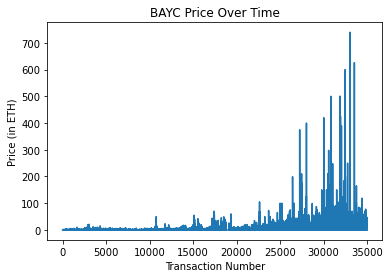

In [18]:
plt.plot(range(BAYC_transfers.shape[0]), BAYC_transfers.transaction_value_eth)
plt.title('BAYC Price Over Time')
plt.xlabel('Transaction Number')
plt.ylabel('Price (in ETH)')
plt.show()

In [19]:
crypto = pd.read_csv('./newCryptoDataset.csv')
crypto_df = pd.DataFrame(crypto)
crypto_df['date'] = pd.to_datetime(crypto_df['date'])

In [20]:
crypto_df.head()

,name,date,average_price
0,Etherium,2022-04-21,"$2,987.48"
1,Etherium,2022-04-20,"$3,077.75"
2,Etherium,2022-04-19,"$3,104.11"
3,Etherium,2022-04-18,"$3,057.61"
4,Etherium,2022-04-17,"$2,993.40"


In [21]:
# Authentication
consumer_key = 'PsRweeqW753BFEtXkwOx29pO6'
consumer_secret = 'PUGywAzvovVBePJWUNqGG4mw4QdgiVk8F49ww0zVtTqqmeJXI4'
access_token = '1460778599791960064-1D8LcmYsRcFol0qNkLd0cW6l4ctMB4'
access_token_secret = 'Uyaake20jbuxlFeT28lhMNnO4TGm6yuEbK4MUuHggs1F0'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAAOxbgEAAAAAFgj%2FxGkntW%2B2jgIIWdbpjjQ9Wy4%3D5cccZuwb034sEYjHJx3OXbIGZ32sjayDZ3v4MWfrBTLUerIQDv'

api = tweepy.Client(
    consumer_key = consumer_key,
    consumer_secret = consumer_secret,
    access_token = access_token,
    access_token_secret = access_token_secret,
    bearer_token = bearer_token,
    wait_on_rate_limit = True
)

In [22]:
tweets = api.search_all_tweets(query = 'BAYC', max_results = 10).data

for tweet in tweets[:5]:
    print('raw tweet: ', tweet.text)
    print('cleaned tweet: ', TweetSentimentAnalyzer.clean_tweet(tweet.text))
    print()

raw tweet:  RT @HiddenLegendNFT: .3 ETH giveaway, 24 hours left to enter! Details below ⬇️⬇️⬇️

#EthereumGiveaway #NFTGiveaway #opensea #NFT #NFTdrop #…
cleaned tweet:  rt hiddenlegendnft .3 eth giveaway 24 hour left enter detail ⬇️⬇️⬇️ ethereumgiveaway nftgiveaway opensea nft nftdrop …

raw tweet:  RT @Baycdrops: Finally!🎊 BAYC LANDS AIRDROP REGISTRATION IS LIVE!
CLAIM NOW: https://t.co/3BDuAuH1TQ
There would be a 2/1 airdrop to the NF…
cleaned tweet:  rt baycdrop final 🎊 bayc land airdrop registr is live claim now http //t.co/3bduauh1tq there would 2/1 airdrop nf…

raw tweet:  RT @KashanNFT: when I bought my MAYC in august, I bought it Bc BAYC was so out of reach I thought I’d never be part of the club.

Today, 1…
cleaned tweet:  rt kashannft i bought mayc august i bought bc bayc reach i thought i ’ never part club today 1…

raw tweet:  @MichealRath1 so a clone of bayc trying convince newbies who missed the original one to buy this and waste their money?
cleaned tweet:  michealrath1 

In [23]:
collections = {
    'BAYC': {
        'start_date': '05/01/21',
        'end_date': '09/25/21',
        'query': 'Bored Ape Yacht Club'
    },
    'COOL': {
        'start_date': '07/01/21',
        'end_date': '09/25/21',
        'query': 'Cool Cats NFT'
    },
    'PPG': {
        'start_date': '07/21/21',
        'end_date': '09/25/21',
        'query': 'Pudgy Penguins'
    }
}

assets = {
    'Bitcoin': {
        'start_date': '01/12/22',
        'end_date': '04/25/22',
        'query': 'bitcoin'
    },
    'Etherium': {
        'start_date': '01/12/22',
        'end_date': '04/25/22',
        'query': 'ethereum'
    }
}

interval = 7
combiner = CryptoTopicCombiner(collections, assets, interval)

In [24]:
tweets_per_interval = 100
combiner.set_analyzer_args(tweets_per_interval, api)

In [25]:
combiner.set_nft_aggregator_args(nfts_df, transfers_df)

In [26]:
combiner.set_crypto_aggregator_args(crypto_df)

In [27]:
combiner.create_dataframe()

tweets analyzed for interval starting at:  05/01/21
tweets analyzed for interval starting at:  05/08/21
tweets analyzed for interval starting at:  05/15/21
tweets analyzed for interval starting at:  05/22/21
tweets analyzed for interval starting at:  05/29/21
tweets analyzed for interval starting at:  06/05/21
tweets analyzed for interval starting at:  06/12/21
tweets analyzed for interval starting at:  06/19/21
tweets analyzed for interval starting at:  06/26/21
tweets analyzed for interval starting at:  07/03/21
tweets analyzed for interval starting at:  07/10/21
tweets analyzed for interval starting at:  07/17/21
tweets analyzed for interval starting at:  07/24/21
tweets analyzed for interval starting at:  07/31/21
tweets analyzed for interval starting at:  08/07/21
tweets analyzed for interval starting at:  08/14/21
tweets analyzed for interval starting at:  08/21/21
tweets analyzed for interval starting at:  08/28/21
tweets analyzed for interval starting at:  09/04/21
tweets analy

In [28]:
combiner.df.head(10)

,interval_start,interval_end,average_price,average_price_normalized,positive,negative,neutral,asset,query
0,2021-05-01,2021-05-08,0.524872,-0.799351,71.0,18.0,11.0,BAYC,Bored Ape Yacht Club
1,2021-05-08,2021-05-15,0.432096,-0.814702,50.0,46.0,4.0,BAYC,Bored Ape Yacht Club
2,2021-05-15,2021-05-22,0.386360,-0.822269,34.0,64.0,2.0,BAYC,Bored Ape Yacht Club
3,2021-05-22,2021-05-29,0.325884,-0.832275,53.0,43.0,4.0,BAYC,Bored Ape Yacht Club
4,2021-05-29,2021-06-05,0.754228,-0.761403,49.0,31.0,20.0,BAYC,Bored Ape Yacht Club
5,2021-06-05,2021-06-12,1.311057,-0.669272,32.0,39.0,29.0,BAYC,Bored Ape Yacht Club
6,2021-06-12,2021-06-19,1.663922,-0.610888,68.0,28.0,4.0,BAYC,Bored Ape Yacht Club
7,2021-06-19,2021-06-26,2.928815,-0.401603,41.0,46.0,13.0,BAYC,Bored Ape Yacht Club
8,2021-06-26,2021-07-03,1.568988,-0.626595,42.0,51.0,7.0,BAYC,Bored Ape Yacht Club
9,2021-07-03,2021-07-10,1.445779,-0.646981,41.0,47.0,12.0,BAYC,Bored Ape Yacht Club


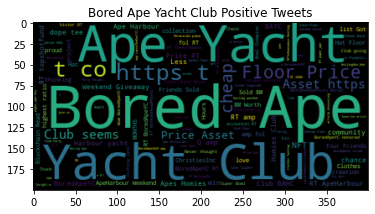

In [29]:
combiner.analyzers['BAYC'].visualize_sentiment('positive')

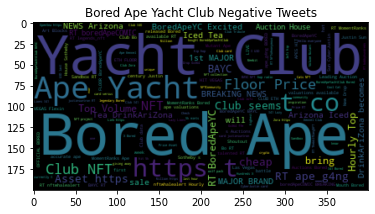

In [30]:
combiner.analyzers['BAYC'].visualize_sentiment('negative')

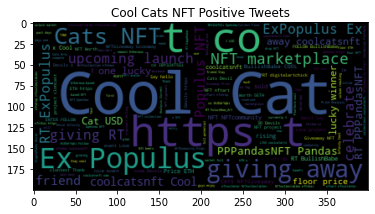

In [31]:
combiner.analyzers['COOL'].visualize_sentiment('positive')

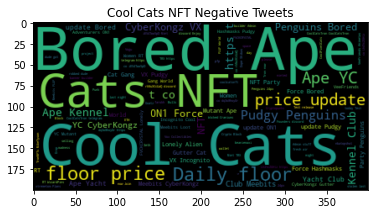

In [32]:
combiner.analyzers['COOL'].visualize_sentiment('negative')

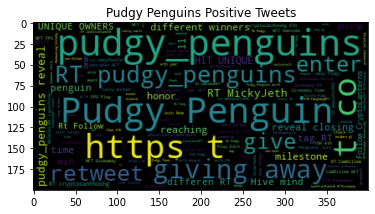

In [33]:
combiner.analyzers['PPG'].visualize_sentiment('positive')

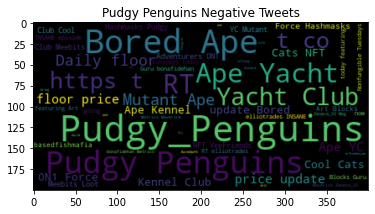

In [34]:
combiner.analyzers['PPG'].visualize_sentiment('negative')

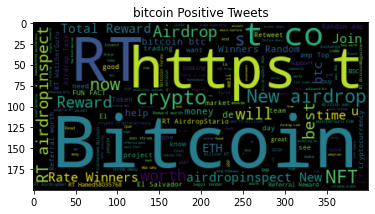

In [35]:
combiner.analyzers['Bitcoin'].visualize_sentiment('positive')

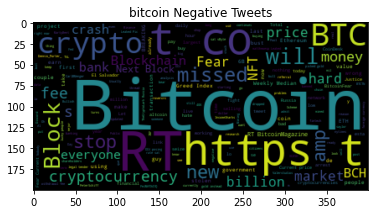

In [36]:
combiner.analyzers['Bitcoin'].visualize_sentiment('negative')

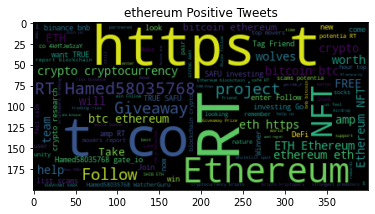

In [37]:
combiner.analyzers['Etherium'].visualize_sentiment('positive')

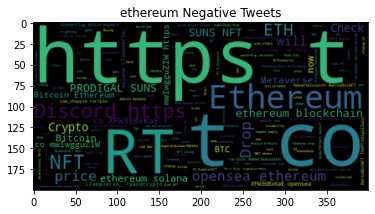

In [38]:
combiner.analyzers['Etherium'].visualize_sentiment('negative')

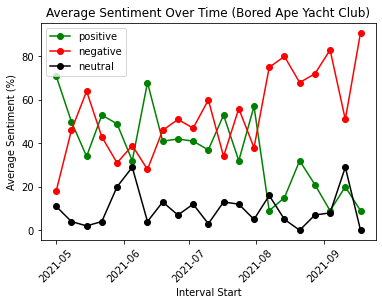

In [39]:
combiner.analyzers['BAYC'].visualize_aggregated_sentiment()

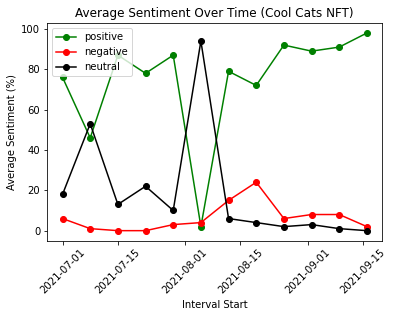

In [40]:
combiner.analyzers['COOL'].visualize_aggregated_sentiment()

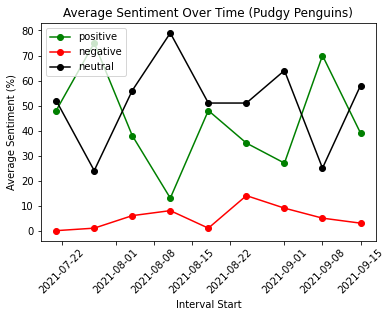

In [41]:
combiner.analyzers['PPG'].visualize_aggregated_sentiment()

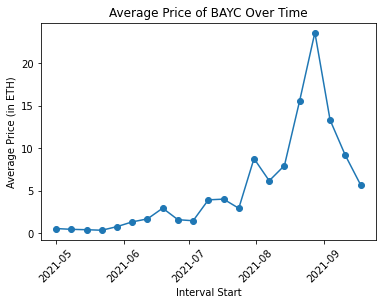

In [44]:
combiner.nft_aggregators['BAYC'].visualize_aggregated_prices()

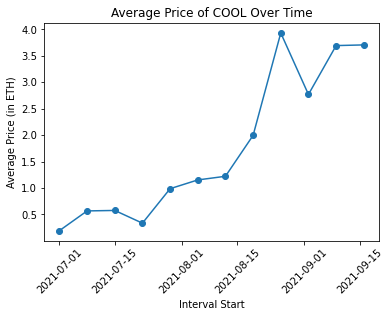

In [46]:
combiner.nft_aggregators['COOL'].visualize_aggregated_prices()

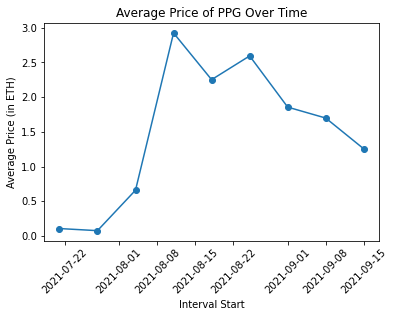

In [47]:
combiner.nft_aggregators['PPG'].visualize_aggregated_prices()

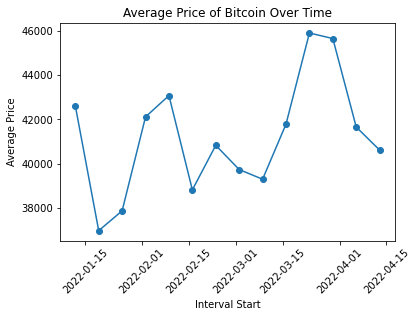

In [48]:
combiner.crypto_aggregators['Bitcoin'].visualize_aggregated_prices()

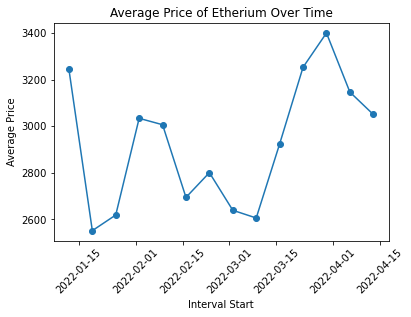

In [49]:
combiner.crypto_aggregators['Etherium'].visualize_aggregated_prices()

In [50]:
predictor = combiner.df['positive'].to_numpy().reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    predictor, combiner.df['average_price_normalized'], test_size = 0.2, random_state = 0
)
regr = LinearRegression().fit(X_train, y_train)
pred = regr.predict(X_test)

In [61]:
print(regr.coef_) # coefficient
print(np.mean((pred - y_test) ** 2)) # errors
print(regr.score(X_test, y_test)) # variance score

[-0.00855081]
0.6589945507717097
-0.25694654910941517


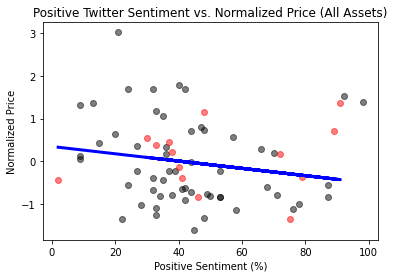

In [62]:
plt.scatter(X_train, y_train, color = "black", alpha = 0.5)
plt.scatter(X_test, y_test, color = "red", alpha = 0.5)
plt.plot(X_test, pred, color = "blue", linewidth = 3)
plt.title('Positive Twitter Sentiment vs. Normalized Price (All Assets)')
plt.xlabel('Positive Sentiment (%)')
plt.ylabel('Normalized Price')
plt.show()

In [52]:
def plot_regression_for_asset(asset, df):
    df_sample = df[df['asset'] == asset]
    X = df_sample['positive'].to_numpy().reshape(-1, 1)
    y = df_sample['average_price']
    regr = LinearRegression().fit(X, y)
    pred = regr.predict(X)

    plt.scatter(X, y, color = "black", alpha = 0.5)
    plt.plot(X, pred, color = "blue", linewidth = 3)
    plt.title('Positive Twitter Sentiment vs. Price (' + asset + ')')
    plt.xlabel('Positive Sentiment (%)')
    plt.ylabel('Price (ETH)')
    plt.show()

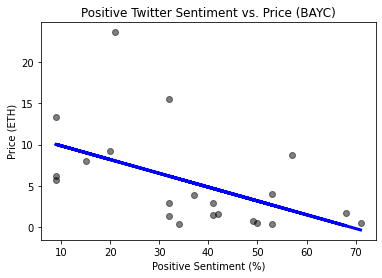

In [53]:
plot_regression_for_asset('BAYC', combiner.df)

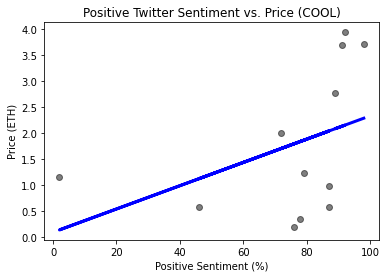

In [54]:
plot_regression_for_asset('COOL', combiner.df)

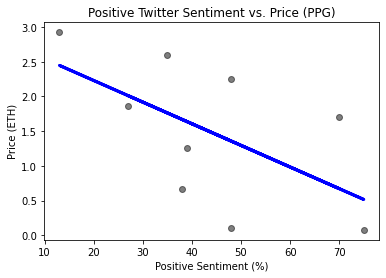

In [55]:
plot_regression_for_asset('PPG', combiner.df)

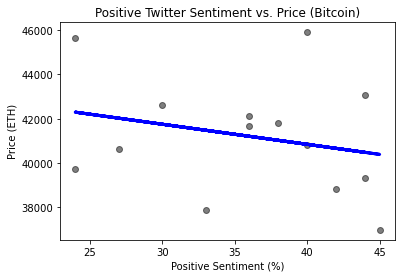

In [56]:
plot_regression_for_asset('Bitcoin', combiner.df)

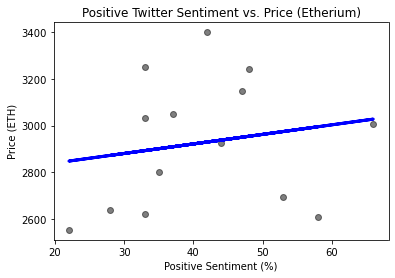

In [58]:
plot_regression_for_asset('Etherium', combiner.df)